In [1]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn.functional as F
import sys
from sklearn.metrics import accuracy_score, recall_score
import random
from tqdm import tqdm

In [15]:
def load_model_for_binary_classification(model_dir='../../data/external/Places365/model'):
    os.makedirs(model_dir, exist_ok=True)

    model_file = os.path.join(model_dir, 'wideresnet18_places365.pth.tar')
    script_file = os.path.join(model_dir, 'wideresnet.py')

    if not os.path.exists(model_file):
        print(f"{model_file} does not exist. Downloading...")
        model_url = 'http://places2.csail.mit.edu/models_places365/wideresnet18_places365.pth.tar'
        download_file(model_url, model_file)

    if not os.path.exists(script_file):
        print(f"{script_file} does not exist. Downloading...")
        script_url = 'https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py'
        download_file(script_url, script_file)

    sys.path.append(model_dir)

    try:
        import wideresnet
        model = wideresnet.resnet18(num_classes=365)
        checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage, weights_only=True)
        state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)

        model.fc = torch.nn.Linear(model.fc.in_features, 2)

        print("Model for binary classification loaded successfully.")
        return model
    except ImportError as e:
        print(f"Error importing wideresnet module: {e}")
        return None


In [37]:
class LandscapesDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
        self.label = self.data_frame['landscape']

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0]) 
        try:
            image = Image.open(image_path).convert('RGB')  
        except (IOError, SyntaxError) as e:
            print(f"Error opening image at {image_path}, skipping to next.")
            return self.__getitem__((idx + 1) % len(self))  
        
        if self.transform:
            image = self.transform(image)
            
        label = int(self.data_frame.iloc[idx, 1])
        return image, torch.tensor(label, dtype=torch.long)

In [38]:
data_path = '/home/ubuntu/landscape-aesthetics/data/processed/landscape_handmade/landscapes.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics')

data = pd.read_csv(data_path)

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])

image_dataset = LandscapesDataset(data_frame=data,
                              root_dir=image_folder,
                              transform=data_transforms)

train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training set size: {len(train_loader.dataset)}")
print(f"Validation set size: {len(val_loader.dataset)}")


Training set size: 2040
Validation set size: 510


Model for binary classification loaded successfully.


Epoch 1/10: 100%|███████████████████| 64/64 [14:20<00:00, 13.45s/it, loss=0.343]

Epoch 1/10, Training Loss: 0.5384


Epoch 1/10, Validation Loss: 0.5994


Epoch 2/10: 100%|███████████████████| 64/64 [14:24<00:00, 13.51s/it, loss=0.352]

Epoch 2/10, Training Loss: 0.4536


Epoch 2/10, Validation Loss: 0.5349


Epoch 3/10: 100%|███████████████████| 64/64 [14:31<00:00, 13.62s/it, loss=0.333]

Epoch 3/10, Training Loss: 0.4169


Epoch 3/10, Validation Loss: 0.8488


Epoch 4/10: 100%|███████████████████| 64/64 [14:36<00:00, 13.70s/it, loss=0.608]

Epoch 4/10, Training Loss: 0.3713


Epoch 4/10, Validation Loss: 0.4467


Epoch 5/10: 100%|███████████████████| 64/64 [14:32<00:00, 13.63s/it, loss=0.297]

Epoch 5/10, Training Loss: 0.3636


Epoch 5/10, Validation Loss: 0.4666


Epoch 6/10: 100%|███████████████████| 64/64 [14:24<00:00, 13.51s/it, loss=0.519]

Epoch 6/10, Training Loss: 0.3264


Epoch 6/10, Validation Loss: 0.4759


Epoch 7/10: 100%|███████████████████| 64/64 [14:11<00:00, 13.30s/it, loss=0.444]

Epoch 7/10, Training Loss: 0.2998


Epoch 7/10, Validation Loss: 0.7926


Epoch 8/10: 100%|███████████████████| 64/64 [14:19<00:00, 13.42s/it, loss=0.288]

Epoch 8/10, Training Loss: 0.2637


Epoch 8/10, Validation Loss: 0.3686


Epoch 9/10: 100%|███████████████████| 64/64 [14:28<00:00, 13.57s/it, loss=0.262]

Epoch 9/10, Training Loss: 0.1995


Epoch 9/10, Validation Loss: 0.3702


Epoch 10/10: 100%|█████████████████| 64/64 [14:08<00:00, 13.25s/it, loss=0.0892]

Epoch 10/10, Training Loss: 0.1663


Epoch 10/10, Validation Loss: 0.4039


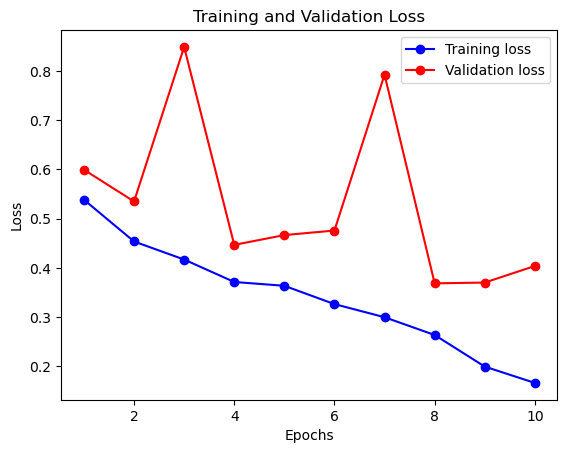

In [45]:
model = load_model_for_binary_classification()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        total_batches = len(train_loader)
        progress_bar = tqdm(enumerate(train_loader), total=total_batches, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (images, labels) in progress_bar:
            images, labels = torch.stack(images), torch.stack(labels)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = torch.stack(images), torch.stack(labels)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        
        scheduler.step()
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')
        
    return train_losses, val_losses, model

train_losses, val_losses, model = train_places365_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

torch.save(model.state_dict(), 'places365_binary_model.pth')

def plot_training_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(train_losses, val_losses)

In [4]:
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load('../../models/places365_binary_model.pth', map_location='cpu', weights_only=True))
model.eval()


data_path = '/home/ubuntu/landscape-aesthetics/data/processed/landscape_handmade/landscapes.csv'
image_folder = Path('/home/ubuntu/landscape-aesthetics')

data = pd.read_csv(data_path)

data_transforms = transforms.Compose([
        # transforms.Resize((256, 256)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ])


# sampled_data = data.sample(n=100, random_state=123) 
image_paths = data.iloc[:, 0].tolist()
true_labels = data.iloc[:, 1].tolist()

from collections import Counter

label_counts = Counter(true_labels)

total_samples = len(true_labels)
label_ratios = {label: count / total_samples for label, count in label_counts.items()}

for label, ratio in label_ratios.items():
    print(f"Label: {label}, Count: {label_counts[label]}, Ratio: {ratio * 100:.2f}%")

predictions = []

for img_path in tqdm(image_paths, desc="Processing images"):

    image_path = os.path.join(image_folder, img_path) 
    
    img = data_transforms(Image.open(image_path).convert('RGB')) .unsqueeze(0)
    
    with torch.no_grad():
        output = model(img)
    
    _, predicted = torch.max(output, 1)
    predictions.append(predicted.item())

accuracy = accuracy_score(true_labels, predictions)
recall = recall_score(true_labels, predictions, average='macro')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')


Label: 1.0, Count: 1566, Ratio: 61.41%
Label: 0.0, Count: 984, Ratio: 38.59%


Processing images: 100%|████████████████████| 2550/2550 [14:35<00:00,  2.91it/s]

Accuracy: 77.80%
Recall: 79.00%
